<a href="https://colab.research.google.com/github/FcoFraguas1987/DS_ML_Portfolio/blob/DS_ML_Bioinformatics/Aprendizaje_supervisado_tecnicas_clasificacion_avanzadas.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# APRENDIZAJE SUPERVISADO TÉCNICAS DE CLASIFICACIÓN AVANZADAS

ás técnicas de clasificación clásicas arrojan modelos interpretables por el ser humano pero que no son tan exactos como los métodos de clasificación avanzados.
Estos últimos modelos, conocidos como "caja negra" presentan una mayor exactitud a la hora de clasificar instancias, tienen un coste computacional superior pero por cotrapartida su forma de clasificar no es conocida.

## Datos del problema a estudiar

Trabajaremos con los datos del estudio de mieloma con los que hemos trabajado hasta ahora. Pre-procesaremos esos datos y los transformaremos en datos con 2 variables de entrada relevante. Además la validación del método será *hold-out*.


In [ ]:
import pandas as pd

#Cargamos los datos ómicos de la matriz de expresión desde un fichero
gene_exp_inmune = pd.read_csv('https://drive.google.com/uc?id=1PYzEIdmnfjOnBpPDIFBE9hL1Lkj_OBCk',index_col=0)
#Cargamos la variable clínica correspondiente a las etiquetas "inmune" vs. "MITF-low"
clinical_info_inmune = pd.read_csv('https://drive.google.com/uc?id=1hHQfcvrFa5Jds-9tW_X4sHjKpYKdii9s',index_col=0)

X, y = gene_exp_inmune, clinical_info_inmune

#Imprimimos las 5 primeras muestras del conjunto de datos para comprobar que se ha cargado correctamente
X.head()

,COL2A1,RXRG,CCL19,SSX1,CST2,PRSS33,CDH2,SCUBE2,TMPRSS13,TRPM8,...,UBASH3A,GBP4,PRF1,PTK6,PCDHB2,GSDMA,DIO2,PLIN1,NCF1C,SLC7A11
0,-1.431141,-7.845756,0.665118,-1.409304,-2.537396,-1.676281,1.529957,-0.895042,-0.298778,5.091742,...,-0.659997,-1.469602,-0.570793,1.047635,-2.068966,-0.202828,-0.506767,1.285256,-0.901222,2.483020
1,-0.424374,-8.352423,0.386055,-2.846138,-0.685105,0.339787,-3.488043,-0.584982,5.679815,-1.117879,...,0.190202,-0.282190,0.375094,0.261662,3.356282,2.028145,-2.399010,-1.152801,0.662490,-2.914991
2,11.014251,0.415549,-1.633781,0.315442,-0.662332,-0.498761,0.535811,-0.467456,-2.818738,1.731049,...,-0.816305,-0.316202,-1.153745,-2.284201,-1.761597,-0.746975,-2.988195,-1.976877,-1.400889,-2.266779
3,-1.180446,-8.187415,-1.958023,5.061146,-2.603744,-0.666706,0.456460,-4.609624,-1.713164,-3.880876,...,0.214344,-0.327110,0.476764,1.153275,-0.337649,-1.006765,-2.686648,-1.329148,0.055994,-2.652313
4,0.816312,-1.189303,4.837235,4.972176,-2.963715,-2.665721,-0.268042,-1.740607,0.011610,-4.107467,...,3.352734,2.145368,3.358865,-2.324389,-1.741669,0.734312,-1.649316,6.284688,1.450729,1.131275


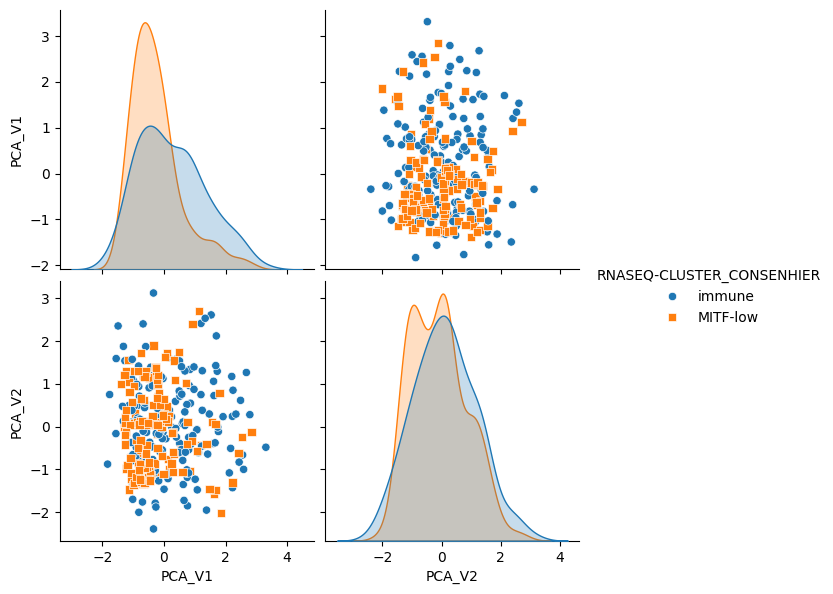

In [ ]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns

#Transformamos el conjunto de datos inicial para que esté representado por solo 2 variables
n_componentes = 2
pca = PCA(n_components=n_componentes)
X_2D = pca.fit_transform(X)

#Standarizamos el rango de cada variable a [0, 1]
st = StandardScaler()
X_2D = st.fit_transform(X_2D)

#Transformamos el conjunto resultando a una estructura data_frame para facilitar la representación gráfica
df = pd.DataFrame(X_2D, columns = ['PCA_V1','PCA_V2'])
df = df.join(y)

#Mostramos en un diagrama de dispersión el nuevo conjunto 2D, junto con las funciones de densidad
sns.pairplot(df, hue='RNASEQ-CLUSTER_CONSENHIER', markers=["o", "s"], height=3);

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

y_int = pd.get_dummies(y).iloc[:,0]
X_2D_train, X_2D_test, y_2D_train, y_2D_test = train_test_split(X_2D, y_int, random_state=42)

print("Numero de instancias en entrenamiento: {}; y test: {}".format(len(X_train),len(X_test)))

Numero de instancias en entrenamiento: 252; y test: 84


## 1 SVM

El SVM *Support Vector Machine* se trata de un modelo de aprendizaje automático que busca un hiperplano que maximice la separación entre las clases. A diferencia de un modelo de regresión linear o logistica sigue una ecuación:

\begin{equation}
\hat{y}(x,w) = w_0 + w_1 \cdot x_1 + \ldots + w_n \cdot x_n
\end{equation}

Entendiendo el hiperplano como un producto escalar entre vectores de variables de entrada $x$ por sus rangos de importancia $w$.


![Margen calculado por la SVM](https://monkeylearn.com/static/7002b9ebbacb0e878edbf30e8ff5b01c/ae702/plot_hyperplanes_annotated.png)

El modelo genera un hiperplano apoyámdose en instancias frontera, aquellos puntos más cercanos al hiperplano, buscando obtener siempre la mayor distancia posible del plano.

Alcanzar ese valor máximo depende de las instancias mal clasificadas (que se encuentran al otro lado de la "frontera"). Esto se paramtriza bajo el nombre de **coste** abreviado como "c". Y es un factor del que dependen los mecanismos que orientan el hiperplano.

El **coste** determina las características del modelo, un bajo coste puede dar lugar a predicciones menos precisas (o tolerar más errores) mientras que un elevado c puede generar problemas de sobreaprendizaje.

----------------------------------------------------------------------

Hay situaciones en los que los datos presenta variables que no se pueden separar mediante un plano o que contienen mucho ruido. Para este tipo de datos los modelos SVM presentan un *kernel-trick*.

En este tipo de situaciones se utilizan funciones de kernel, de este modo se aumenta la dimensionalidad de los datos alterando el espacio entre los mismos. Este paso requiere el uso de funciones no linealtes, y tras este ajuste se puede realizar una búsqueda de un hiperplano.

![Kernel trick](https://miro.medium.com/v2/resize:fit:1312/1*jSsTgN9CsXZhy2mOKw07bw.png)

Las funciones tuilizadas tienen caracter polinomial o son funciones radiales.

- Función polinomial: Se trata de una función más sencilla de forma $K(x,w) = \langle x, w \rangle ^d$. Con esta transformación se consigue que la sumatoria lineal de los productos de pesos $w_i$ y variables $x_i$ de polinomio de mayor grado $d$. Así, en lugar de un hiperplano o "línea recta" tendremos una división de los datos más compleja. Siempre que el grado sea menor a 5 los problemas de sobreaprendizaje reduciran su tendencia de aparición.  
- Función *Radial Base Function* (RBF): $K(x,w) = e^{-\frac{\|x-w\|^2}{2\cdot\sigma}}$. Estas funciones terminana generando separaciones con un mayor éxito, pero su efectividad depende de cómo se gestione el valor "gamma" ($\gamma$), ya que valores altos del mismo generarán problemas de sobreaprendizaje. Con el uso de funciones RBF las funciones discriminantes no-lineales en este caso se representan como áreas "circulares".



In [ ]:
from sklearn import svm
from sklearn.metrics import accuracy_score
import warnings
warnings.filterwarnings("ignore")

clf = svm.SVC(probability=True) #generamos el modelo y habilitamos un parámetro para que se pueda calcular AUC
clf.fit(X_train,y_train)

y_pred = clf.predict(X_test)
acc = accuracy_score(y_test,y_pred)
print("El porcentaje de acierto obtenido es",acc*100)

El porcentaje de acierto obtenido es 83.33333333333334


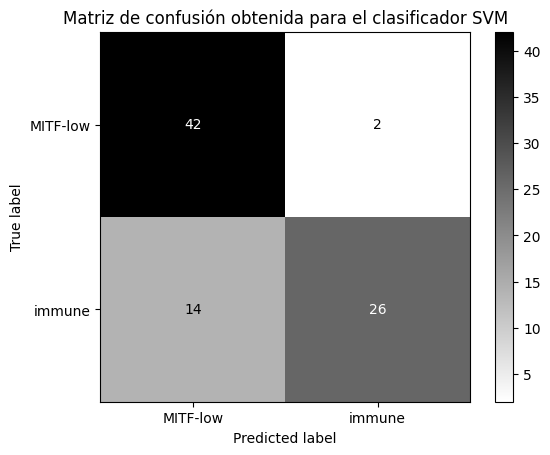

              precision    recall  f1-score   support

    MITF-low       0.75      0.95      0.84        44
      immune       0.93      0.65      0.76        40

    accuracy                           0.81        84
   macro avg       0.84      0.80      0.80        84
weighted avg       0.84      0.81      0.80        84

La medida F1 para el clasificador MLPClassifier es 0.7647
La medida AUC para el clasificador MLPClassifier es 0.8330


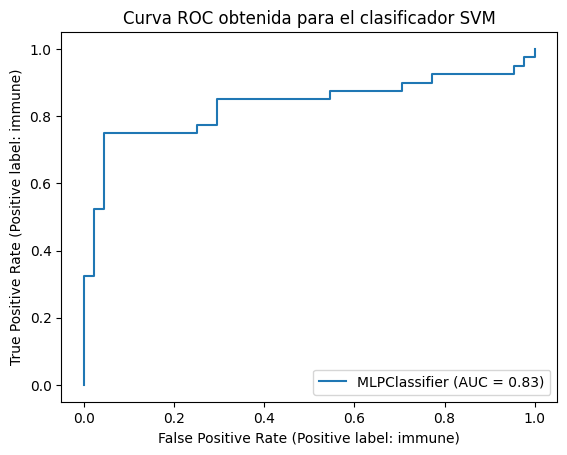

In [ ]:
from sklearn import metrics
import matplotlib.pyplot as plt

metrics.ConfusionMatrixDisplay.from_estimator(clf, X_test, y_test,cmap='binary')
plt.title("Matriz de confusión obtenida para el clasificador SVM")
plt.show()

print(metrics.classification_report(y_test,y_pred))

f1 = metrics.f1_score(y_test,y_pred,pos_label='immune')
print("La medida F1 para el clasificador %s es %.4f"%(clf.__class__.__name__,f1))

y_probs = clf.predict_proba(X_test)
auc = metrics.roc_auc_score(y_test, y_probs[:,1])
print("La medida AUC para el clasificador %s es %.4f"%(clf.__class__.__name__,auc))
metrics.RocCurveDisplay.from_estimator(clf, X_test, y_test)
plt.title("Curva ROC obtenida para el clasificador SVM")
plt.show()

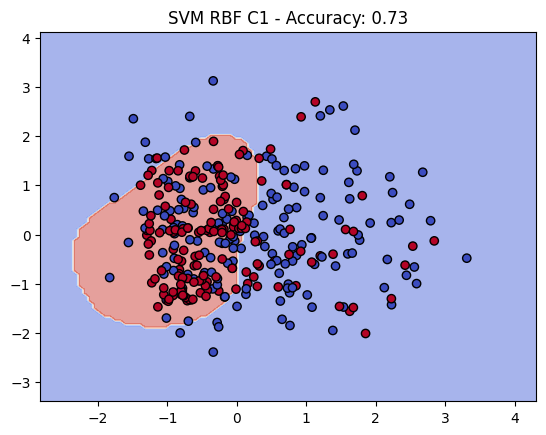

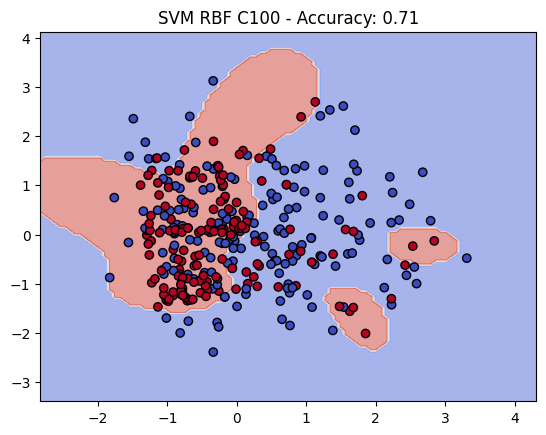

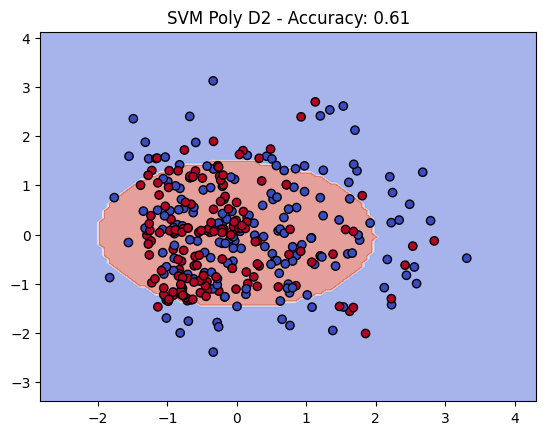

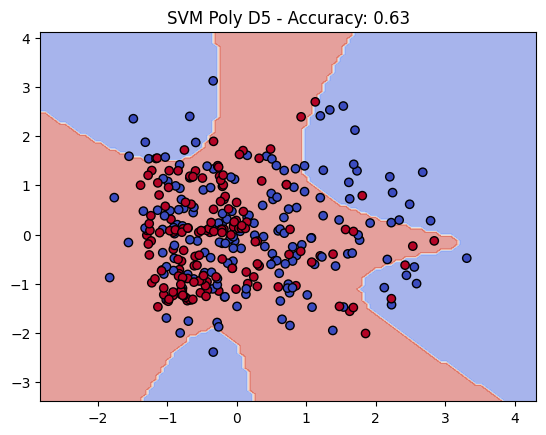

In [ ]:
#Se importa una biblioteca especial para pintar en 2D
from sklearn.inspection import DecisionBoundaryDisplay
import itertools

#Creamos y entrenamos los clasificadores SVM con los datos 2D
svm_rbf_1 = svm.SVC(kernel='rbf',C=1)
svm_rbf_100 = svm.SVC(kernel='rbf',C=100)
svm_poly_2 = svm.SVC(kernel='poly',degree=2,C=1)
svm_poly_5 = svm.SVC(kernel='poly',degree=5,C=1)
svms = [svm_rbf_1, svm_rbf_100, svm_poly_2, svm_poly_5] #lista

#Parámetros que se utilizarán para visualizar la figura
scatter_kwargs = {'s': 120, 'edgecolor': None, 'alpha': 0.7}
contourf_kwargs = {'alpha': 0.2}
scatter_highlight_kwargs = {'s': 120, 'label': 'Test data', 'alpha': 0.7}

identificador = ['SVM RBF C1', 'SVM RBF C100', 'SVM Poly D2', 'SVM Poly D5']
for clf, etq, grd in zip(svms, identificador, itertools.product([0, 1], repeat=2)):
    clf.fit(X_2D_train, y_2D_train)
    score = clf.score(X_2D_test,y_2D_test)
    fig = DecisionBoundaryDisplay.from_estimator(clf, X_2D,
                                              response_method="predict",
                                              alpha=0.5,
                                              cmap=plt.cm.coolwarm)
    fig.ax_.scatter(X_2D[:, 0], X_2D[:, 1],
                 c=y_int, edgecolor="k",
                 cmap=plt.cm.coolwarm)

     # Agrega el título
    fig.ax_.set_title(f'{etq} - Accuracy: {score:.2f}')

    plt.show()

### 2.1 Características de las SVM
Las SVM son eficaces en problemas con una alta dimensionalidad, obtienen buenas predicciones incluso cuando el número de variables de entrada es alto.
También son eficiente en memoria. El modelo se basa únicamente en almacenar los "vectores soporte" encontrados en entrenamiento. Y es un modelo que se adapta bien a distintos problemas configurando la función kernel más apropiada en cada caso de estudio.


Las principales limitaciones es que requieren de problemas de clasificación binarios con variables numéricas. Obtener un buen modelo requiere una dificil parametrización, no existen protoclos de prueba o acercamiento ótimo a la mejor solución, así que muchas veces requiere de ensayo y error. Además se añade que a veces las métricas de calidad de modelo, principalmente la AUC no otorga valores fiables.


## 3 Redes Neuronales

Se trata de un complejo que busca asemejarse al cerebro humano. Las redes neuronales se componen de pequeñas unidades (neuronas) que cooperan para resolver un problema.

Estas neuronas se organizan en diferentes capas que trabajan ordenadamente:
* Primeras capas: reciben información.
* Capas centrales: Procesan los datos, este procesamiento no se ve fuera del sistema. Aumentar las neuronas dentro de estas capas generará el "*Deep Learning"*, aumentando la capacidad de aprendizaje para resolver los problemas más compeljos.
* Las últimas capas son las que generan la respuesta.

---------------------------------------------------------------------------

LA red se compoone de unidades básicas **perceptrón**, matemáticamente el perceptrón toma unos valores de entrada, los procesa y generá unos valores de salida. Para generar los valores de salida la neurona debe aplicar la *función de activación* que hace que la neurona pondere las entradas y los pesos. La *función de activación* suele ser una función tipo escalón que se dispara ante ciertos valores de entrada.


![Representación del perceptron (tomado de Wikipedia)](https://upload.wikimedia.org/wikipedia/commons/thumb/3/31/Perceptron.svg/706px-Perceptron.svg.png)


La estructura de un perceptrón se puede considerar como un clasificador lineal básico.

-------------------------------------------------------------------------

#### Las capas ocultas

Se consideran **capaso coultas** todas aquellas localizadas entre la entrada y saluida de datos, las capas que procesan las variables de las instancias.


Em estas capas, las neuronas toman las salidas de la capa anterior y aplican sus pesos (a través de la función de activación) pasando sus resultados. La misma función de activación permite que la red aprende (patrones complejor) de los datos.

Los perceptrones entre las capas generan una comunicación con los datos. Este tipo de sistema se denomina Perceptrón Multi-capa. En el caso de que todos los perceptrones de cada capa se conecten con todos los perceptrones de la capa posterior, hablaremos de un sistema totalmente conectado *fully-connected*.


![Ejemplo de ANN con una única capa oculta](https://upload.wikimedia.org/wikipedia/commons/thumb/1/11/Colored_neural_network_es.svg/420px-Colored_neural_network_es.svg.png)

---------------------------------------------------------------------


#### Relación con la Función de Activación
La función de activación determina si la neurona debe enviar una señal o no, en función de la suma ponderada de sus entradas.

Algunas de las funciones de activación más comunes son:

- **ReLU (Rectified Linear Unit)**: $f(x) = max(0, x)$. Suele ser eficiente en ciertos probelmas de aprendizaje.
- **Sigmoid**: $f(x) = \frac{1}{1 + e^{(-x)}}$. Muy util en problemas de clasificación binaria.
- **Tanh (Tangente hiperbólica)**: $f(x) = \frac{e^x - e^{(-x)}}{e^x + e^{(-x)}}$. Util en datos con variables de valores positivos y negativos.

----------------------------------------------------------------------

#### Entrenamiento mediante retroalimentación (backpropagation): Un Viaje de Aprendizaje

Entrenar una neurona con datos implica un reajuste de su estructura. Esto es una alteraciñon en los valores de los pesos entre las conexiones de las neuronas, conocidas como **parámetros de la red**. A mayor número de parámetros tendremos una red más compleja, que aprenderá a resolver problemas más complejos con elevado coste computacional.

Los pasos del aprendizaje son:

![Imagen de aprendizaje en ResearchGate](https://www.researchgate.net/publication/349004454/figure/fig5/AS:987143862226949@1612364845991/Figura-8-Esquema-del-aprendizaje-supervisado-en-Redes-Neuronales-Artificiales-Fuente.png)

Entrenar una ANN es un proceso fascinante que se asemeja al aprendizaje humano basado en ejemplos. Imagina a una ANN como un estudiante que mejora su desempeño a través de la práctica constante. En concreto, lo que realmente se ajusta en la estructura de una ANN son los valores de los pesos en las conexiones entre neuronas. Esto es lo que se denominan los **parámetros de la red**. A mayor número de parámetros, mayor será la complejidad de la red para aprender problemas más difíciles, pero a mayor coste computacional.

A continuación, se explora cómo funciona este proceso de entrenamiento, haciendo hincapié en términos sencillos y conceptos clave.

##### Paso 1: Inicialización y Pesos Aleatorios
Se comienza con una red neuronal vacía (solo la estructura de neuronas en capas). Lo que permite que los pesos de las conexiones entre las neuronas se inicializan aleatoriamente.

##### Paso 2: Alimentación Hacia Adelante (*Forward Propagation*)
La red recibe los datos de entrenamiento, esta información se propaga hacia adelante. Cada neruona realiza cálculos teniendo en cuenta:
* la información de entrada
* los pesos de las conexiones
Tras esto, se genera una respuesta de red (en la neurona de salida) que genera una clasificación.

##### Paso 3: Comparación con la Respuesta Deseada
La red compara su respuesta con la respuesta deseada (la respuesta correcta).  Esta comparación genera un "error", que mide qué tan cerca o lejos está la red de la respuesta correcta. Este error se mide mediante lo que se denomina como función de pérdida o **loss function**.

##### Paso 4: Retropropagación del Error (*Backpropagation*)
Aquí entra en juego la "retroalimentación". La red ajusta sus conexiones (pesos) en función del error. Si la respuesta es incorrecta, la red modifica sus conexiones de manera que la próxima vez se acerque más a la respuesta deseada. Este proceso se llama "backpropagation" y se asemeja al aprendizaje basado en retroalimentación que los estudiantes hacen para mejorar.

##### Tasa de Aprendizaje (*Learning Rate*):
Imagina que el estudiante tiene una tasa de aprendizaje, que determina cuánto cambia sus respuestas en función de sus errores. Si la tasa de aprendizaje es alta, aprende rápidamente pero puede ser *inestable*. Si es baja, aprende lentamente pero con mayor precisión.

##### Iteración y Práctica Constante:
Este proceso se repite muchas veces. Con cada ciclo de entrenamiento, la ANN se genera un modelo más exacto. A través del backpropagation, la tasa de aprendizaje y la regularización, la red neuronal aprende a resolver problemas de manera efectiva. Así, podemos identificar la denominada *convergencia de la red*, es decir su efectividad en el correcto ajuste al problema en cada ciclo.

#### Cálculo de la salida de una red neuronal y Extensión a Múltiples Clases

Hasta este punto, hemos hablado principalmente de redes neuronales con una sola neurona de salida, lo que permite codificar un valor binario $\{ 0,1 \}$ según supere o no un umbral de activación, por defecto mediante la función sigmoide. Esto las hace ideales para problemas de decisión dicotómicas, como diagnosticar enfermedades como presentes o ausentes.

En casos en lso que se necesite una respuesta de clasificación no dicotómica, utilizamos un número más alto de neuronas junto con funciones de activación especiales para extender la salida de una red neuronal a múltiples clases. Una función común es la función **"Softmax"**. Esta función calcula la probabilidad de que una muestra pertenezca a cada clase, y la suma de estas probabilidades es igual a 1.

Así que, la salida de la red se extiende para acomodar diferentes clases, y las funciones de activación como `Softmax` permiten asignar probabilidades a cada clase. Esta es la magia que permite a las redes neuronales manejar problemas de múltiples clases.

In [ ]:

from sklearn.neural_network import MLPClassifier

# Creamos y entrenamos la red neuronal (random_state se usa para ofrecer los mismos resultados cada vez que se ejecuta)
clf = MLPClassifier(hidden_layer_sizes=(10,), max_iter=1000, random_state=42)
clf.fit(X_train, y_train)

#Probamos su calidad predictiva
y_pred = clf.predict(X_test)
acc = accuracy_score(y_test,y_pred)
print("El porcentaje de acierto obtenido es",acc*100)


El porcentaje de acierto obtenido es 80.95238095238095


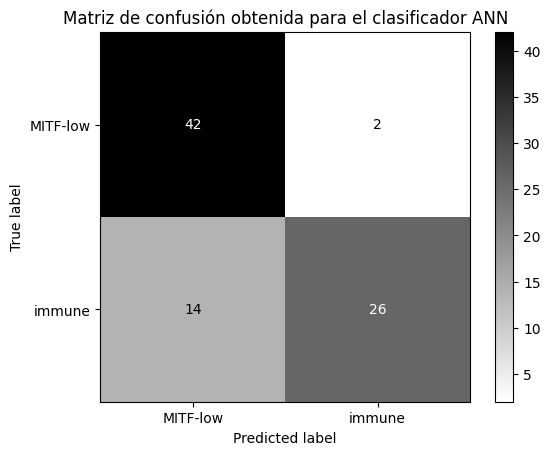

              precision    recall  f1-score   support

    MITF-low       0.75      0.95      0.84        44
      immune       0.93      0.65      0.76        40

    accuracy                           0.81        84
   macro avg       0.84      0.80      0.80        84
weighted avg       0.84      0.81      0.80        84

La medida F1 para el clasificador MLPClassifier es 0.7647
La medida AUC para el clasificador MLPClassifier es 0.8330


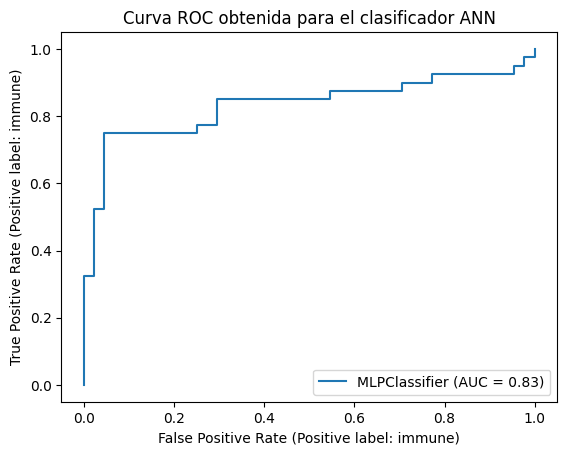

In [ ]:
metrics.ConfusionMatrixDisplay.from_estimator(clf, X_test, y_test,cmap='binary')
plt.title("Matriz de confusión obtenida para el clasificador ANN")
plt.show()

print(metrics.classification_report(y_test,y_pred))

f1 = metrics.f1_score(y_test,y_pred,pos_label='immune')
print("La medida F1 para el clasificador %s es %.4f"%(clf.__class__.__name__,f1))

y_probs = clf.predict_proba(X_test)
auc = metrics.roc_auc_score(y_test, y_probs[:,1])
print("La medida AUC para el clasificador %s es %.4f"%(clf.__class__.__name__,auc))
metrics.RocCurveDisplay.from_estimator(clf, X_test, y_test)
plt.title("Curva ROC obtenida para el clasificador ANN")
plt.show()

<Figure size 1200x900 with 0 Axes>

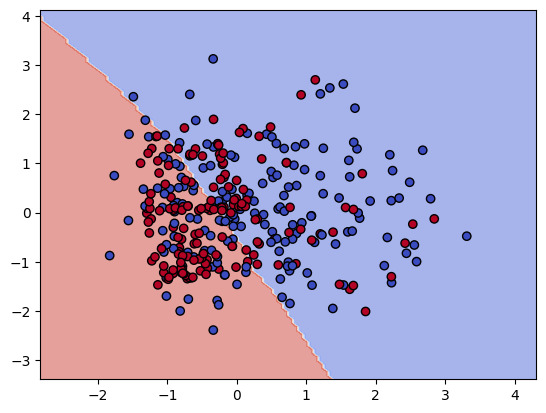

In [ ]:
#Creamos y entrenamos el clasificador con los datos 2D
clf = MLPClassifier(hidden_layer_sizes=(10,), max_iter=1000, random_state=42)
clf.fit(X_2D_train, y_2D_train)
score = clf.score(X_2D_test,y_2D_test)

fig = plt.figure(figsize=(12,9))
fig = DecisionBoundaryDisplay.from_estimator(clf, X_2D,
                                              response_method="predict",
                                              alpha=0.5,
                                              cmap=plt.cm.coolwarm)

fig.ax_.scatter(X_2D[:, 0], X_2D[:, 1],
                 c=y_int, edgecolor="k",
                 cmap=plt.cm.coolwarm)

plt.show()

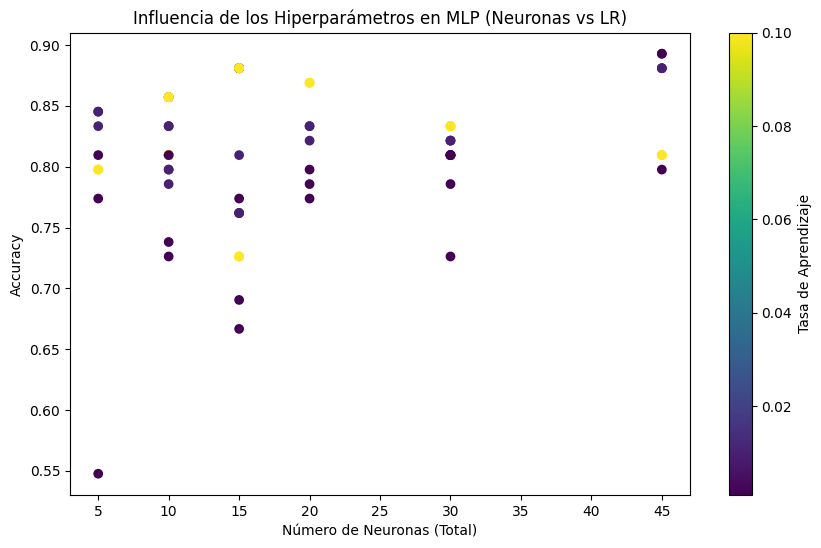

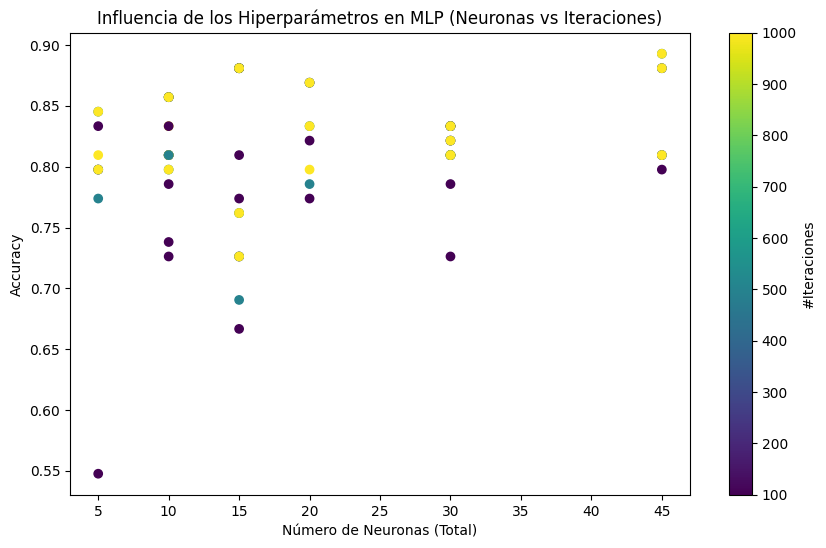

In [ ]:
#Veamos la influencia de algunos de estos parámetros en los resultados (tardará algunos segundos en ejecutar)
import numpy as np

# Parámetros que vamos a variar
num_layers = [1, 2, 3]
num_neurons = [5, 10, 15]
learning_rates = [0.001, 0.01, 0.1]
max_iterations = [100, 500, 1000]

# Almacenaremos los resultados del accuracy
accuracies = []

# Iteramos a través de diferentes configuraciones
for layers in num_layers:
    for neurons in num_neurons:
        for rate in learning_rates:
            for iterations in max_iterations:
                clf = MLPClassifier(hidden_layer_sizes=(neurons,) * layers, max_iter=iterations, learning_rate_init=rate, random_state=42)
                clf.fit(X_train, y_train)
                accuracy = clf.score(X_test, y_test)
                accuracies.append((layers, neurons, rate, iterations, accuracy))

# Extraemos los valores de precisión
accuracies = np.array(accuracies)

# Mostramos los resultados gráficamente
plt.figure(figsize=(10, 6))
plt.scatter(accuracies[:, 0] * accuracies[:, 1], accuracies[:, 4], c=accuracies[:, 2], cmap='viridis')
plt.xlabel('Número de Neuronas (Total)')
plt.ylabel('Accuracy')
plt.title('Influencia de los Hiperparámetros en MLP (Neuronas vs LR)')
plt.colorbar(label='Tasa de Aprendizaje')
plt.show()

# Mostramos los resultados gráficamente
plt.figure(figsize=(10, 6))
plt.scatter(accuracies[:, 0] * accuracies[:, 1], accuracies[:, 4], c=accuracies[:, 3], cmap='viridis')
plt.xlabel('Número de Neuronas (Total)')
plt.ylabel('Accuracy')
plt.title('Influencia de los Hiperparámetros en MLP (Neuronas vs Iteraciones)')
plt.colorbar(label='#Iteraciones')
plt.show()

Con lo mostrado en la gráfica anterior vamos a repetir el análsis con una red de 30 neuronas con 800 iteraciones. Ya que, 30 es un número grande pero que no generará un aprendizaje con tanto coste compputacional como 40 neuronas y 800 repeticiones nos va a permitir alcanzar una exactitud del 80% aprox.

In [ ]:
# Creamos y entrenamos la red neuronal (random_state se usa para ofrecer los mismos resultados cada vez que se ejecuta)
clf = MLPClassifier(hidden_layer_sizes=(30,), max_iter=800, random_state=42)
clf.fit(X_train, y_train)

#Probamos su calidad predictiva
y_pred = clf.predict(X_test)
acc = accuracy_score(y_test,y_pred)
print("El porcentaje de acierto obtenido es",acc*100)


El porcentaje de acierto obtenido es 84.52380952380952


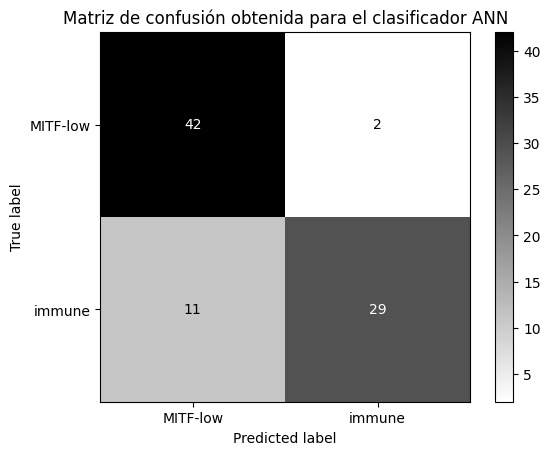

              precision    recall  f1-score   support

    MITF-low       0.79      0.95      0.87        44
      immune       0.94      0.72      0.82        40

    accuracy                           0.85        84
   macro avg       0.86      0.84      0.84        84
weighted avg       0.86      0.85      0.84        84

La medida F1 para el clasificador MLPClassifier es 0.8169
La medida AUC para el clasificador MLPClassifier es 0.8869


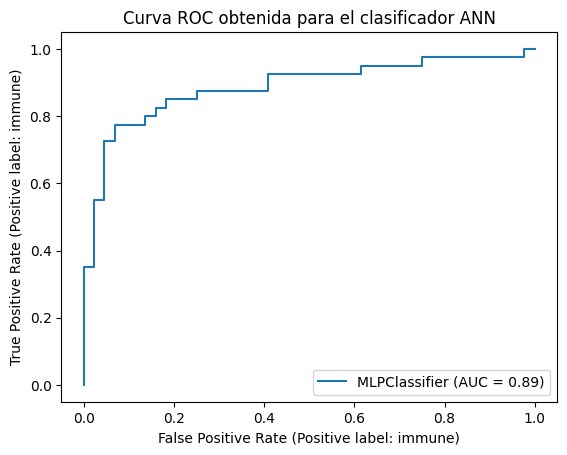

In [ ]:
metrics.ConfusionMatrixDisplay.from_estimator(clf, X_test, y_test,cmap='binary')
plt.title("Matriz de confusión obtenida para el clasificador ANN")
plt.show()

print(metrics.classification_report(y_test,y_pred))

f1 = metrics.f1_score(y_test,y_pred,pos_label='immune')
print("La medida F1 para el clasificador %s es %.4f"%(clf.__class__.__name__,f1))

y_probs = clf.predict_proba(X_test)
auc = metrics.roc_auc_score(y_test, y_probs[:,1])
print("La medida AUC para el clasificador %s es %.4f"%(clf.__class__.__name__,auc))
metrics.RocCurveDisplay.from_estimator(clf, X_test, y_test)
plt.title("Curva ROC obtenida para el clasificador ANN")
plt.show()

<Figure size 1200x900 with 0 Axes>

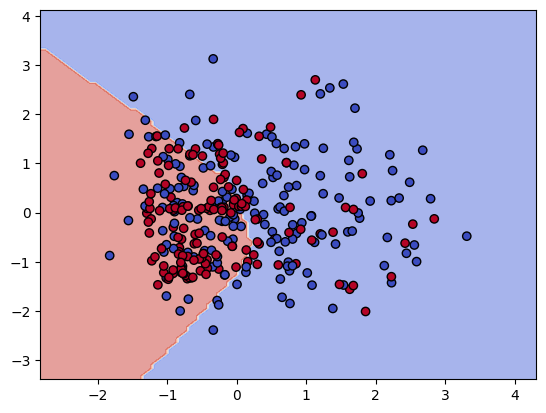

In [ ]:
#Creamos y entrenamos el clasificador con los datos 2D
clf = MLPClassifier(hidden_layer_sizes=(30,), max_iter=800, random_state=42)
clf.fit(X_2D_train, y_2D_train)
score = clf.score(X_2D_test,y_2D_test)

fig = plt.figure(figsize=(12,9))
fig = DecisionBoundaryDisplay.from_estimator(clf, X_2D,
                                              response_method="predict",
                                              alpha=0.5,
                                              cmap=plt.cm.coolwarm)

fig.ax_.scatter(X_2D[:, 0], X_2D[:, 1],
                 c=y_int, edgecolor="k",
                 cmap=plt.cm.coolwarm)

plt.show()

La predicción con estas características ha mejorado con respecto a la anterior. En términos de exactituda, de matriz de confusión y en el límite de decisión.

#### 3.1 Ventajas y desventajas de las Redes Neuronales

Las redes neuronales tiene capacidad para aprender modelos lineales y no lineales siendo versátiles netre problemas de clasificación (binaria o multimodal) o Regresión. Pueden extrar características relevantes y lidiar con datos ruidosos. Además permiten un reajuste del modelo trabanjando a tiempo real.

Por contra Requiere una gran cantidad de datos de entrenamiento, que si es muy grande provoca un procesamiento muy lento. Además no maneja bien variables no numéricas y requiere de un ajuste de hiperparámetros.Puede ser sensible a las escalas de las caracterósitcas de los datos y su función de pérdida, que realiza ajustes en las caracterísitcas de la red, puede tener problemas para salir de mínimos locales.
